# Option Mispricing Classifier: Using Neural Networks to Clasify Black Scholes Trading Entries

---

## Objective

Build a hybrid quantitative Machine Learning pipeline that uses Black-Scholes as a feature generator and a neural network (MLP) classifier to decide whether an option is sufficiently mispriced to justify entering a trade, factoring in transaction costs and risk.

In [83]:
# Getting all the necessary libraries
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from scipy.special import erf

# Get SK-learn libraries for data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb

## Data Collection
-	Options Market Data
  - By using the greeks, we will generate prices for the options prices and strikes
- Underlying Asset Data
  - Prices generated by the GBM


In [ ]:
dataset = pd.read_csv("options_mispricing_data.csv")

In [51]:
dataset.head()

,symbol,datetime,expiry,right,strike,spot,mid,bsm_price,exit_datetime,net_pnl,...,mis_z,delta,gamma,vega,theta,rho,iv,moneyness,dte_days,volume
0,SPY250306C00508000,2025-02-27 21:31:05.083263+00:00,2025-03-06 21:31:05.083263+00:00,C,508.0,510.789158,7.766145,7.875761,2025-02-27 21:31:05.083263,-1.688307,...,-0.789385,0.580552,0.024727,27.634313,-166.018361,5.536024,0.223351,1.005490,7.0,59.0
1,SPY250306C00509000,2025-02-27 21:31:05.083263+00:00,2025-03-06 21:31:05.083263+00:00,C,509.0,510.789158,7.308690,7.317008,2025-02-27 21:31:05.083263,-1.665434,...,0.348176,0.555590,0.025011,27.937712,-167.492825,5.302214,0.223242,1.003515,7.0,83.0
2,SPY250306C00510000,2025-02-27 17:31:05.083263+00:00,2025-03-06 17:31:05.083263+00:00,C,510.0,509.995528,6.464068,6.367921,2025-02-27 21:31:05.083263,-37.601306,...,0.646155,0.510388,0.025310,28.159728,-168.246836,4.869845,0.223046,0.999991,7.0,174.0
3,SPY250306C00510000,2025-02-27 21:31:05.083263+00:00,2025-03-06 21:31:05.083263+00:00,C,510.0,510.789158,6.823849,6.783379,2025-02-27 21:31:05.083263,-1.641192,...,0.118629,0.530430,0.025196,28.130555,-168.319830,5.065981,0.223133,1.001547,7.0,130.0
4,SPY250306C00511000,2025-02-27 21:31:05.083263+00:00,2025-03-06 21:31:05.083263+00:00,C,511.0,510.789158,6.203414,6.274985,2025-02-27 21:31:05.083263,-1.610171,...,-1.606856,0.505173,0.025280,28.210852,-168.489688,4.828307,0.223024,0.999587,7.0,184.0


In [52]:
dataset.to_csv("data.csv")

## EDA

For this part of the analysis we will explore the data a little further, there is no need to get in deep with this dataset since the data already has some assumptions, based on the synthetic nature of it.

In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   symbol         266 non-null    object             
 1   datetime       266 non-null    datetime64[ns, UTC]
 2   expiry         266 non-null    datetime64[ns, UTC]
 3   right          266 non-null    object             
 4   strike         266 non-null    float64            
 5   spot           266 non-null    float64            
 6   mid            266 non-null    float64            
 7   bsm_price      266 non-null    float64            
 8   exit_datetime  266 non-null    datetime64[ns]     
 9   net_pnl        266 non-null    float64            
 10  label          266 non-null    int64              
 11  mispricing     266 non-null    float64            
 12  mis_z          266 non-null    float64            
 13  delta          266 non-null    float64            

In [54]:
dataset[['label', 'mispricing']].head()

,label,mispricing
0,0,-0.109616
1,0,-0.008319
2,0,0.096146
3,0,0.040469
4,0,-0.071572


In [55]:
dataset.isna().sum()

,0
symbol,0
datetime,0
expiry,0
right,0
strike,0
spot,0
mid,0
bsm_price,0
exit_datetime,0
net_pnl,0


In [56]:
dataset[['spot','strike','iv','delta','gamma','vega','theta','rho']].describe()

,spot,strike,iv,delta,gamma,vega,theta,rho
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,537.976210,537.766917,0.223504,0.017705,0.021884,33.727543,-157.286485,-0.001121
std,14.915150,14.960520,0.000976,0.503572,0.004167,9.911828,27.549303,8.898812
min,509.995528,508.000000,0.222598,-0.592058,0.011205,27.579380,-184.410217,-24.445679
25%,521.109283,521.000000,0.222946,-0.477254,0.022773,28.652201,-172.345520,-5.275086
50%,541.138147,542.000000,0.223200,0.013002,0.023541,29.592458,-168.092935,0.060638
75%,549.761069,552.000000,0.223424,0.521560,0.024448,30.539668,-159.449527,5.447086
max,561.792745,560.000000,0.226592,0.618061,0.025310,62.036288,-79.315904,23.336047


In [57]:
dataset.groupby("symbol")["datetime"].is_monotonic_increasing.all()

np.True_

<Axes: title={'center': 'Underlying Price Path'}, xlabel='datetime'>

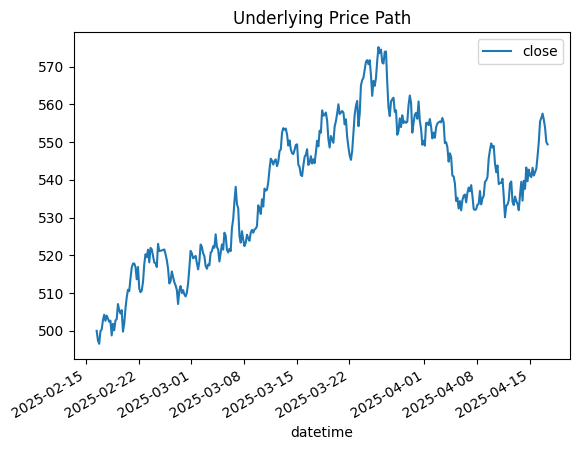

In [60]:
under_df.plot(x="datetime", y="close", title="Underlying Price Path")

<Axes: >

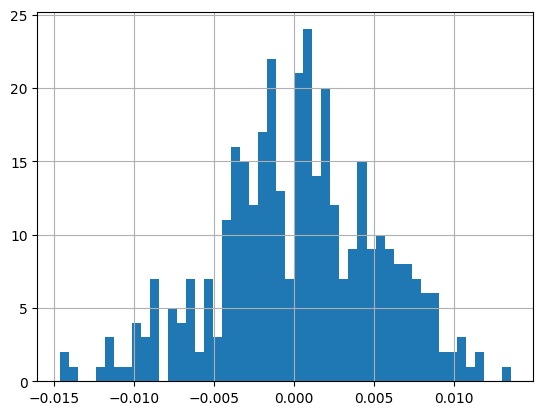

In [61]:
returns = np.log(under_df['close']).diff().dropna()
returns.hist(bins=50)

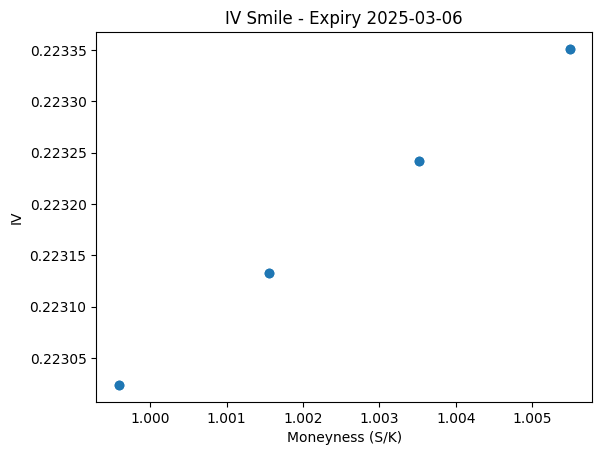

In [62]:
sample_expiry = dataset['expiry'].iloc[0]
smile_data = dataset[dataset['expiry'] == sample_expiry]
plt.scatter(smile_data['moneyness'], smile_data['iv'])
plt.xlabel('Moneyness (S/K)')
plt.ylabel('IV')
plt.title(f"IV Smile - Expiry {sample_expiry.date()}")
plt.show()

<Axes: xlabel='dte_days'>

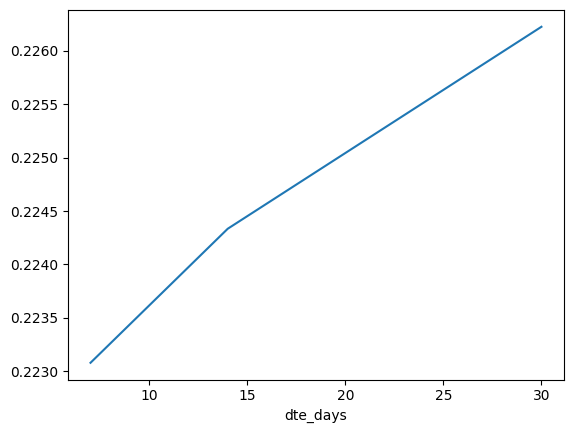

In [63]:
dataset.groupby("dte_days")["iv"].mean().plot()

<Axes: xlabel='moneyness', ylabel='delta'>

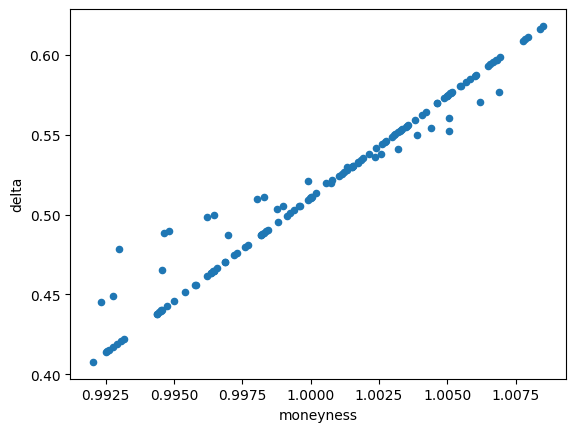

In [64]:
dataset[dataset['right']=="C"].plot.scatter(x='moneyness', y='delta')

<Axes: xlabel='moneyness', ylabel='gamma'>

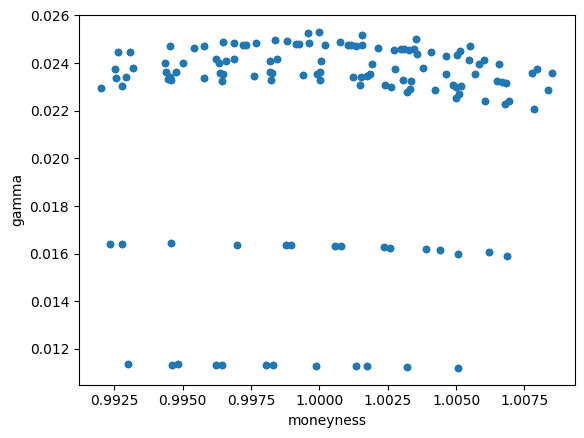

In [65]:
dataset.plot.scatter(x='moneyness', y='gamma')

<Axes: xlabel='dte_days', ylabel='vega'>

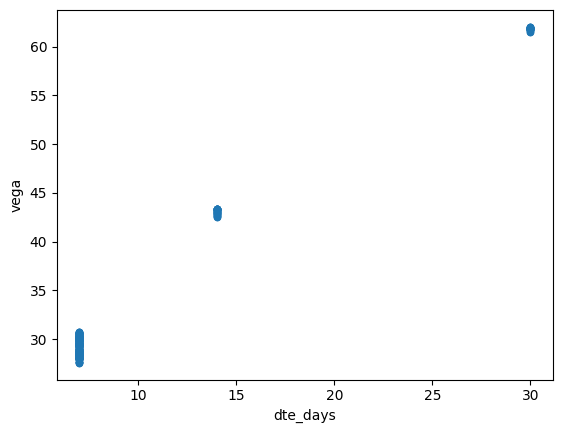

In [66]:
dataset.plot.scatter(x='dte_days', y='vega')

<Axes: >

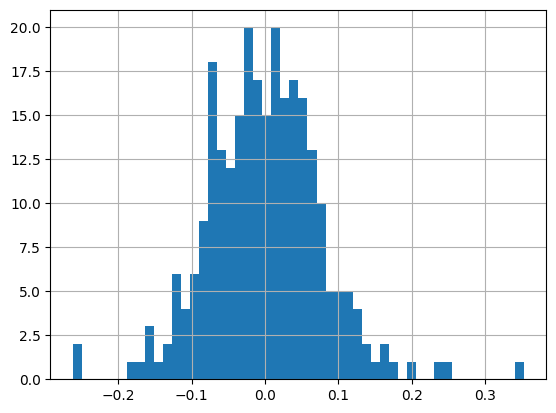

In [67]:
dataset['mispricing'].hist(bins=50)

<Axes: xlabel='label', ylabel='mispricing'>

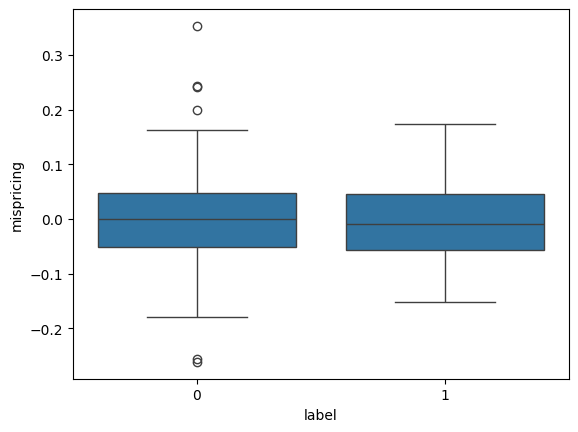

In [68]:
sns.boxplot(x="label", y="mispricing", data=dataset)

<Axes: >

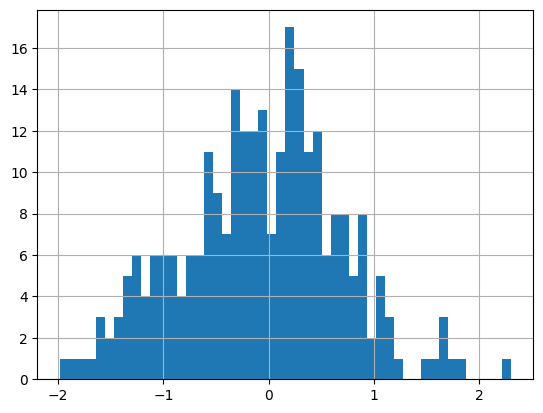

In [69]:
dataset['mis_z'].hist(bins=50)

In [70]:
dataset['label'].value_counts(normalize=True)

,proportion
label,
0,0.759398
1,0.240602


<Axes: >

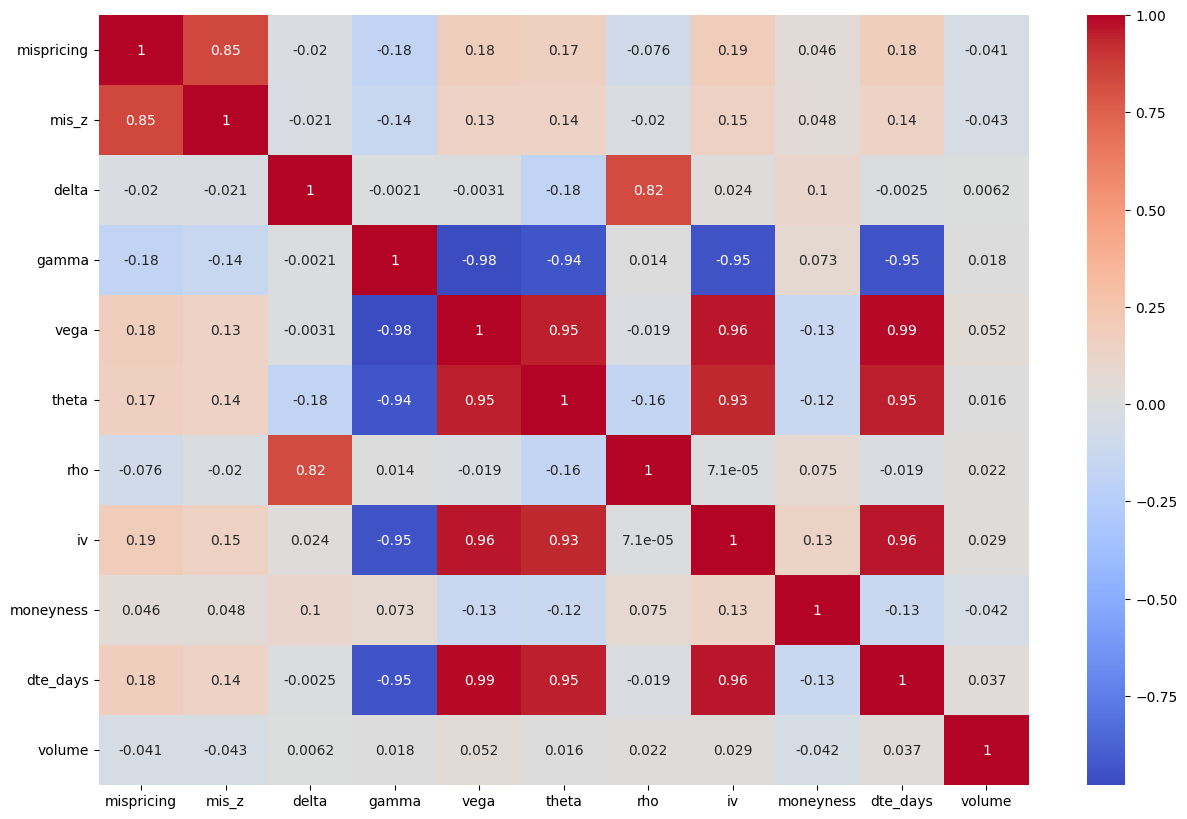

In [73]:
plt.figure(figsize=(15,10))
corr = dataset[['mispricing','mis_z','delta','gamma','vega','theta','rho','iv','moneyness','dte_days','volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

<Axes: title={'center': 'Average IV Over Time'}, xlabel='datetime'>

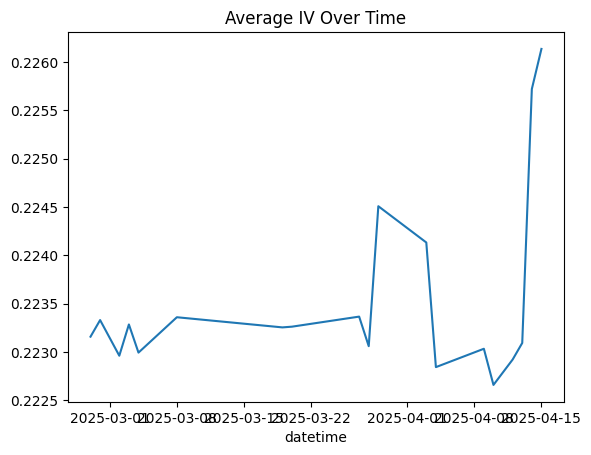

In [75]:
dataset.groupby(dataset['datetime'].dt.date)['iv'].mean().plot(title="Average IV Over Time")

<Axes: title={'center': 'Avg Mispricing Z-score Over Time'}, xlabel='datetime'>

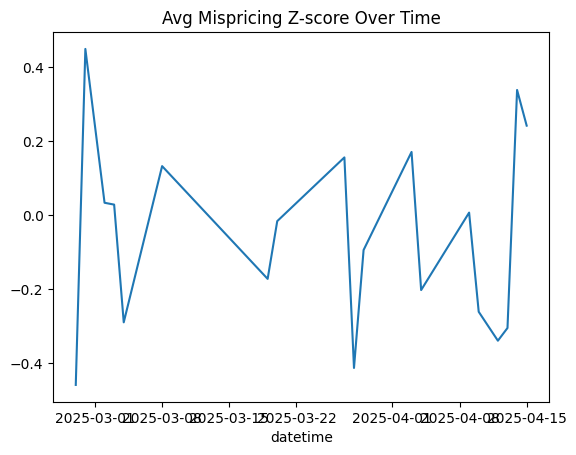

In [76]:
dataset.groupby(dataset['datetime'].dt.date)['mis_z'].mean().plot(title="Avg Mispricing Z-score Over Time")

In [77]:
dataset.groupby(["right", pd.cut(dataset['moneyness'], bins=[0,0.95,1.05,10])])['mispricing'].mean()

/tmp/ipython-input-2169265782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset.groupby(["right", pd.cut(dataset['moneyness'], bins=[0,0.95,1.05,10])])['mispricing'].mean()


right  moneyness   
C      (0.0, 0.95]          NaN
       (0.95, 1.05]   -0.002503
       (1.05, 10.0]         NaN
P      (0.0, 0.95]          NaN
       (0.95, 1.05]    0.001716
       (1.05, 10.0]         NaN
Name: mispricing, dtype: float64


Average Mispricing by Moneyness Bucket & Option Type:
 moneyness_bucket  OTM Put       ATM  OTM Call
right                                        
C                     NaN -0.002503       NaN
P                     NaN  0.001716       NaN

Average Mispricing by DTE Bucket & Option Type:
 dte_bucket  Ultra Short (0-7)  Short (8-30)  Medium (31-90)  Long (>90)
right                                                                  
C                   -0.004234      0.004292             NaN         NaN
P                   -0.008322      0.041123             NaN         NaN

Average Mispricing by Moneyness & DTE:
 moneyness_bucket  dte_bucket       
OTM Put           Ultra Short (0-7)         NaN
                  Short (8-30)              NaN
                  Medium (31-90)            NaN
                  Long (>90)                NaN
ATM               Ultra Short (0-7)   -0.006278
                  Short (8-30)         0.022707
                  Medium (31-90)            NaN
         

/tmp/ipython-input-2370225834.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_mispricing_moneyness = dataset.groupby(["right", "moneyness_bucket"])["mispricing"].mean().unstack()
/tmp/ipython-input-2370225834.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_mispricing_dte = dataset.groupby(["right", "dte_bucket"])["mispricing"].mean().unstack()
/tmp/ipython-input-2370225834.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

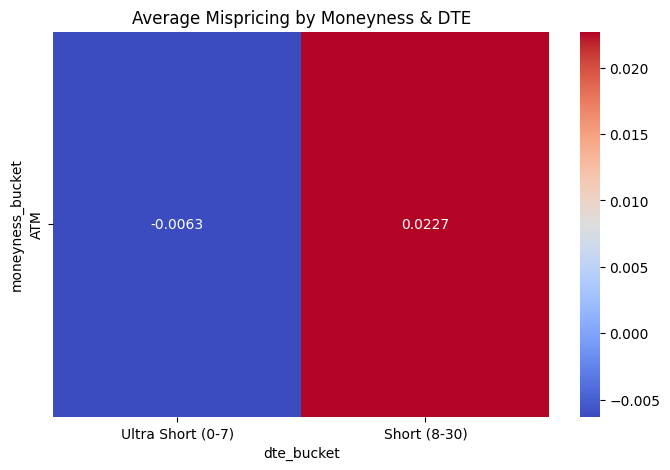

In [78]:
# Define moneyness buckets
moneyness_bins = [0, 0.95, 1.05, np.inf]
moneyness_labels = ["OTM Put", "ATM", "OTM Call"]
dataset["moneyness_bucket"] = pd.cut(dataset["moneyness"], bins=moneyness_bins, labels=moneyness_labels)

# Define DTE buckets
dte_bins = [0, 7, 30, 90, np.inf]
dte_labels = ["Ultra Short (0-7)", "Short (8-30)", "Medium (31-90)", "Long (>90)"]
dataset["dte_bucket"] = pd.cut(dataset["dte_days"], bins=dte_bins, labels=dte_labels)

# 1️⃣ Average mispricing by moneyness & option type
avg_mispricing_moneyness = dataset.groupby(["right", "moneyness_bucket"])["mispricing"].mean().unstack()
print("\nAverage Mispricing by Moneyness Bucket & Option Type:\n", avg_mispricing_moneyness)

# 2️⃣ Average mispricing by DTE & option type
avg_mispricing_dte = dataset.groupby(["right", "dte_bucket"])["mispricing"].mean().unstack()
print("\nAverage Mispricing by DTE Bucket & Option Type:\n", avg_mispricing_dte)

# 3️⃣ Cross effect: moneyness vs DTE
avg_mispricing_cross = dataset.groupby(["moneyness_bucket", "dte_bucket"])["mispricing"].mean()
print("\nAverage Mispricing by Moneyness & DTE:\n", avg_mispricing_cross)

# Optional: Pivot for heatmap visualization
pivot_heatmap = dataset.pivot_table(
    values="mispricing",
    index="moneyness_bucket",
    columns="dte_bucket",
    aggfunc="mean"
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_heatmap, annot=True, fmt=".4f", cmap="coolwarm")
plt.title("Average Mispricing by Moneyness & DTE")
plt.show()

## Looking at the results

Looking at the theorical data, we can see that the dataset has realistic and close to theory values. Even thought some results might look skwed is fine, the dataset works properly for this research.

In [81]:
# One-hot encode option type (C/P)
dataset_encoded = pd.get_dummies(dataset, columns=["right"], drop_first=True)

features = [
    "mispricing", "mis_z", "delta", "gamma", "vega", "theta", "rho",
    "iv", "moneyness", "dte_days", "volume", "strike", "spot", "right_P"
]
X = dataset_encoded[features]
y = dataset_encoded["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [82]:
train_cutoff = dataset_encoded["datetime"].quantile(0.8)
train_mask = dataset_encoded["datetime"] <= train_cutoff

X_train, X_test = X_scaled[train_mask], X_scaled[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

In [85]:
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    force_row_wise=True
)
model.fit(X_train, y_train)

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, probs))

[LightGBM] [Info] Number of positive: 50, number of negative: 158
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 208, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240385 -> initscore=-1.150572
[LightGBM] [Info] Start training from score -1.150572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


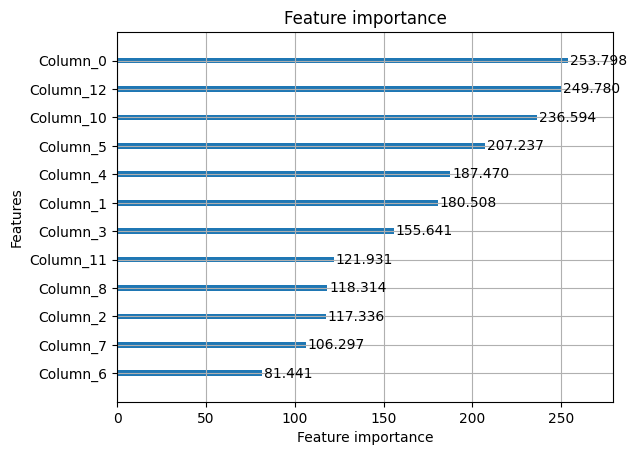

In [90]:
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.show()

In [88]:
roc_auc_score(y_test, 1 - probs)

np.float64(0.5275974025974026)

([<matplotlib.axis.YTick at 0x7b567c17c590>,
 [Text(0, 0, 'mispricing'),
  Text(0, 1, 'mis_z'),
  Text(0, 2, 'delta'),
  Text(0, 3, 'gamma'),
  Text(0, 4, 'vega'),
  Text(0, 5, 'theta'),
  Text(0, 6, 'rho'),
  Text(0, 7, 'iv'),
  Text(0, 8, 'moneyness'),
  Text(0, 9, 'dte_days'),
  Text(0, 10, 'volume'),
  Text(0, 11, 'strike'),
  Text(0, 12, 'spot'),
  Text(0, 13, 'right_P')])

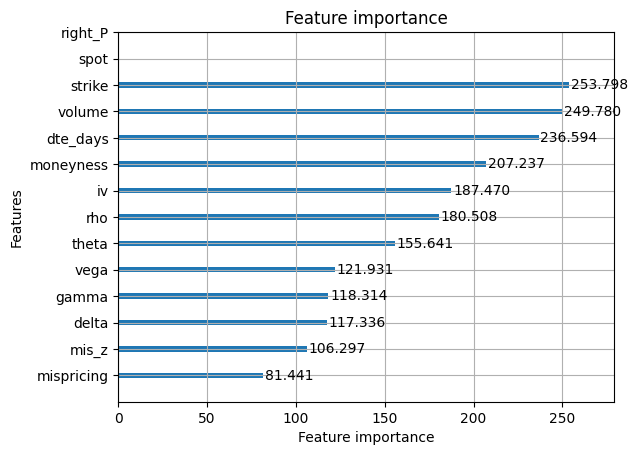

In [91]:
lgb.plot_importance(model, max_num_features=15, importance_type="gain")
plt.yticks(ticks=range(len(features)), labels=features)

## Training a Multilayer Perceptron (MLP)

The model is just a basic fully connected Neural Network. This model should be able to learn and predict better than the LightGBM with a AUC score of 0.54.

## MLP Conclusion

The model end up giving a AUC of 0.597, which in fact is better than the lighGBM, this proves that the Neural Network has more power to understand the nonlinear relationships of the market. Overall this experiment was tested on experimental data and imporvemnts must be made.

## Improvements

As future improvements the data should be more descriptive, it is also possible to use PCA for feature reduction and other techniques for better results. Overall the experiments has flaws and many theorical assumptions.

## Final Thoughts

By now we have more evidence that in fact Neural Networks can learn intuition, which was previously stated as a human only ability. More research and statiscal test should be made to prove this hypothesis true.